### 컴퓨터 비전을 위한 딥러닝
이번 Post에서는 CNN을 활용하여 Image Dataset에 대한 Model을 생성하고 알아본다.    

이에 관하여 알아두면 좋은 Post는 아래 링크를 참조하자.  
1. <a href="https://wjddyd66.github.io/dl/CNN-(1)-CNN%EC%9D%B4%EB%9E%80/">CNN (1) CNN이란</a>
2. <a href="https://wjddyd66.github.io/dl/CNN-(2)-CNN%EC%A2%85%EB%A5%98/">CNN (2) CNN종류</a>
3. <a href="https://wjddyd66.github.io/dl/CNN-(3)-CNN%EA%B5%AC%ED%98%84/">CNN (3) CNN구현</a>

<br>

처음 Post에서도 언급하였듯이 자세한 수식이나 원리에 대해서는 미리 Post한 곳을 참조하고 Keras Category에서는 최대한 Keras 사용법에 집중한다.

<br><br>
#### 필요한 라이브러리 Import

In [2]:
import matplotlib.pyplot as plt
import cv2
import os, shutil
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import load_model
from keras import backend as K
from keras.preprocessing import image
import numpy as np
from keras.applications.vgg16 import preprocess_input, decode_predictions

### Cat vs Dog
간단한 Cat vs Dog를 실시하기 위한 Dataset은 Keras자체에서 제공하고 있지 않다.  
따라서 Kaggle에서 다운로드가 필요하며 링크를 참조하자. <a href="https://www.kaggle.com/c/dogs-vs-cats/data">Kaggle Data</a>(812MB의 크기이므로 현재 Github에는 올리지 못합니다.)<br> 

Kaggle의 Dataset은 현재 강아지와 고양이 이미지가 각 클래스마다 1만2500개의 Dataset을 가지고 있습니다.  
따라서 다음의 과정을 거쳐서 Dataset을 변형합니다.  
- Train Dataset: 각 클래스마다 1000개의 Image
- Validation Dataset: 각 클래스마다 500개의 Image
- Test Dataset: 각 클래스마다 500개의 Image


In [2]:
#원본 Dataset Directory
original_dataset_dir = './Dataset/train'

#저장할 Root Dataset Directory
base_dir = './Dataset/cat_dog'
os.mkdir(base_dir)

#각각의 Dataset의 용도에 따라 Root Directory 안에 Directory 생성
train_dir = os.path.join(base_dir,'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir,'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir,'test')
os.mkdir(test_dir)

#위에서 생성한 Directory에 Class별로 Directory 생성
train_cats_dir = os.path.join(train_dir,'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir,'dogs')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir,'cats')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir,'dogs')
os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir,'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir,'dogs')
os.mkdir(test_dogs_dir)

#2000개의 고양이 이미지를 1000, 500, 500개씩 Train, Validation, Test Cat Directory로 복사
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(train_cats_dir,fname)
    shutil.copyfile(src,dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1000,1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(validation_cats_dir,fname)
    shutil.copyfile(src,dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1500,2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(test_cats_dir,fname)
    shutil.copyfile(src,dst)
    
#2000개의 강아지 이미지를 1000, 500, 500개씩 Train, Validation, Test Cat Directory로 복사
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(train_dogs_dir,fname)
    shutil.copyfile(src,dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000,1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(validation_dogs_dir,fname)
    shutil.copyfile(src,dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1500,2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(test_dogs_dir,fname)
    shutil.copyfile(src,dst)

#### 데이터셋 확인

In [3]:
print('Train Cat Image Count: ',len(os.listdir(train_cats_dir)))
print('Train Dog Image Count: ',len(os.listdir(train_dogs_dir)))
print('Validation Cat Image Count: ',len(os.listdir(validation_cats_dir)))
print('Validation Dog Image Count: ',len(os.listdir(validation_dogs_dir)))
print('Test Cat Image Count: ',len(os.listdir(test_cats_dir)))
print('Test Dog Image Count: ',len(os.listdir(test_dogs_dir)))

('Train Cat Image Count: ', 1000)
('Train Dog Image Count: ', 1000)
('Validation Cat Image Count: ', 500)
('Validation Dog Image Count: ', 500)
('Test Cat Image Count: ', 500)
('Test Dog Image Count: ', 500)


#### Model 구성
<code>layers.Conv2D(output_channel_size,KernelSize(row,col),padding='valid or same',input_shape,activation)</code>
- output_channel_size: 출력되는 Output의 Feature개수(Channel 개수)
- KernelSize: KernelSize
- Padding: Valid or Same
- input_shape: 입력 Image의 크기
- activation: Activation Function 정의

<br>
Strides도 직접 지정할 수 있다.  
밑의 Code에서는 Stride와 Padding을 사용하지 않아서 Default값인 Stride=(1,1), Padding='valid'를 사용하였다.  
참고사항으로 아래 <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D">Keras 홈페이지</a>에서 제공하는 Conv2D의 초기값에 대한 설명이다.  

```code
__init__(
    filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    data_format=None,
    dilation_rate=(1, 1),
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)
```
<br>

<code>layers.MaxPooling2D(pool_size=(row,col))</code>: pool_size()에 맞게 Polling을 실시한다 만약 pool_size(2,2)라면 Image의 Size를 가로 세로 각각 1/2로 줄인다는 뜻이다.  

<code>layers.Flatten()</code>: Vector를 일차원으로 만드는 과정

In [4]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

print(model.summary())

W1202 01:36:03.845230 139946432952128 deprecation_wrapper.py:119] From /home/jovyan/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

#### 데이터 전처리
1. Image이미로 0 ~ 255의 RGB값으로 이루워진 Pixel을 0~1값으로 나타낸다.
2. Pytorch와 마찬가지로 Directory를 기준으로 하여 자동으로 Size조정, Batch, Label을 자동으로 할당할 수 있다.


In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Model Training & Model Save
위에서 Generator를 통하여 쉽게 데이터 전처리 과정을 거칠 수 있었다.  
하지만 Generator의 문제는 **계속하여 Data를 생성한다는 것 이다.**  
따라서 Model을 Training할때는 <code>model.fit_generator()</code>를 통하여 생성하고 다음과 같은 Parameter를 정의하여야 한다.
- train_generator: 생성한 train_generator
- steps_per_epoch: 한 Epoch에 사용한 Step수 Generator에서 2000개의 Image를 batch_size를 20으로 지정하였으므로 2000/20 = 100
- epoch: 반복 회수
- validation_generator: 생성한 validation_generator
- validation_epoch: 한 Epoch 종료 시 마다 검증할 때 사용되는 검증 스텝 수를 지정. 총 1000개의 Image를 batch_size=20으로 지정하였으므로 1000/20 = 50


In [6]:
model.compile(loss='binary_crossentropy',
             optimizer = optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data = validation_generator,
    validation_steps=50)

model.save('./Model/cats_and_dogs_small_1.h5')

W1202 01:36:04.164474 139946432952128 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_impl.py:180: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1202 01:36:05.096580 139946432952128 deprecation_wrapper.py:119] From /home/jovyan/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/30
100/100 [==============================] - 7s 66ms/step - loss: 0.6880 - acc: 0.5495 - val_loss: 0.6345 - val_acc: 0.6140
Epoch 2/30
100/100 [==============================] - 6s 55ms/step - loss: 0.6456 - acc: 0.6240 - val_loss: 0.6439 - val_acc: 0.6540
Epoch 3/30
100/100 [==============================] - 6s 57ms/step - loss: 0.5843 - acc: 0.6960 - val_loss: 0.8376 - val_acc: 0.6240
Epoch 4/30
100/100 [==============================] - 5s 55ms/step - loss: 0.5525 - acc: 0.7115 - val_loss: 0.5029 - val_acc: 0.6430
Epoch 5/30
100/100 [==============================] - 6s 55ms/step - loss: 0.5272 - acc: 0.7355 - val_loss: 0.5772 - val_acc: 0.6710
Epoch 6/30
100/100 [==============================] - 6s 59ms/step - loss: 0.5001 - acc: 0.7550 - val_loss: 0.5847 - val_acc: 0.6190
Epoch 7/30
100/100 [==============================] - 6s 58ms/step - loss: 0.4780 - acc: 0.7675 - val_loss: 0.6454 - val_acc: 0.6970
Epoch 8/30
100/100 [==============================] - 6s 60ms/step - 

#### Accuracy & Loss 확인
**Overfitting 발생 확인 가능**

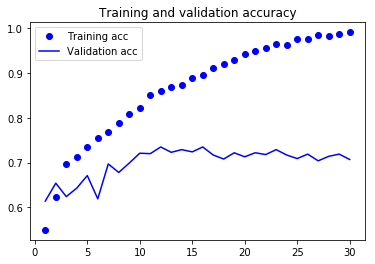

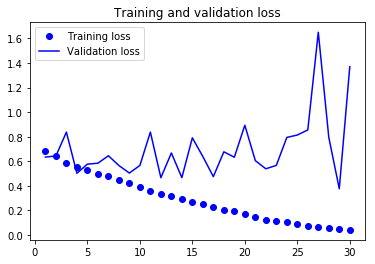

In [7]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Overfitting 해결방안(1) 데이터 증식
위에서 사용한 Generator를 활용하여 이미지의 개수를 Pytorch와 같이 회전이나 shift등을 시켜 개수를 증가시킨다.

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    batch_size=32,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Overfitting 해결방안(2) Dropout
기존 Model에 Dropout Layer추가  
Dropout에 대한 자세한 내용: <a href="https://wjddyd66.github.io/dl/NeuralNetwork-(5)-Others/">NeuralNetwork (5) 학습 관련 기술들</a>

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

#### Model Training & Save

In [10]:
model.compile(loss='binary_crossentropy',
             optimizer = optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data = validation_generator,
    validation_steps=50)

model.save('./Model/cats_and_dogs_small_2.h5')

Epoch 1/100
100/100 [==============================] - 22s 225ms/step - loss: 0.6941 - acc: 0.5182 - val_loss: 0.6867 - val_acc: 0.5152
Epoch 2/100
100/100 [==============================] - 20s 197ms/step - loss: 0.6781 - acc: 0.5701 - val_loss: 0.6017 - val_acc: 0.5992
Epoch 3/100
100/100 [==============================] - 19s 194ms/step - loss: 0.6536 - acc: 0.6032 - val_loss: 0.7567 - val_acc: 0.6301
Epoch 4/100
100/100 [==============================] - 20s 198ms/step - loss: 0.6351 - acc: 0.6278 - val_loss: 0.6336 - val_acc: 0.6340
Epoch 5/100
100/100 [==============================] - 19s 193ms/step - loss: 0.6237 - acc: 0.6443 - val_loss: 0.5777 - val_acc: 0.6516
Epoch 6/100
100/100 [==============================] - 21s 211ms/step - loss: 0.6051 - acc: 0.6709 - val_loss: 0.5866 - val_acc: 0.6572
Epoch 7/100
100/100 [==============================] - 19s 194ms/step - loss: 0.6022 - acc: 0.6708 - val_loss: 0.5852 - val_acc: 0.6631
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 20s 203ms/step - loss: 0.4084 - acc: 0.8122 - val_loss: 0.4171 - val_acc: 0.8209
Epoch 62/100
100/100 [==============================] - 21s 211ms/step - loss: 0.3943 - acc: 0.8216 - val_loss: 0.3417 - val_acc: 0.8033
Epoch 63/100
100/100 [==============================] - 21s 211ms/step - loss: 0.4149 - acc: 0.8144 - val_loss: 0.5231 - val_acc: 0.8119
Epoch 64/100
100/100 [==============================] - 20s 205ms/step - loss: 0.3848 - acc: 0.8242 - val_loss: 0.0510 - val_acc: 0.7861
Epoch 65/100
100/100 [==============================] - 21s 207ms/step - loss: 0.3923 - acc: 0.8254 - val_loss: 0.3483 - val_acc: 0.7766
Epoch 66/100
100/100 [==============================] - 21s 214ms/step - loss: 0.4029 - acc: 0.8169 - val_loss: 0.2881 - val_acc: 0.7764
Epoch 67/100
100/100 [==============================] - 21s 206ms/step - loss: 0.3969 - acc: 0.8169 - val_loss: 0.6127 - val_acc: 0.7951
Epoch 68/100
100/100 [===================

#### Accuracy & Loss 확인
**Overfitting 해소 확인 가능**

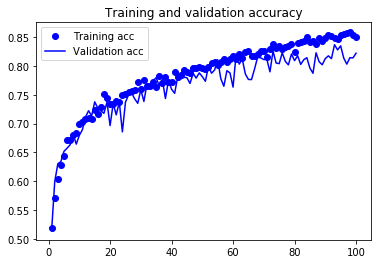

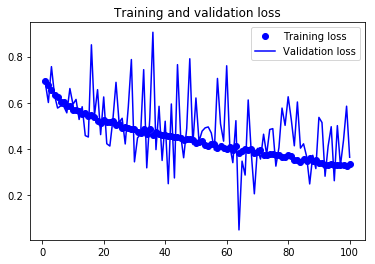

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### FineTuning
Keras자체에서는 CNN의 종류중 다음과 같은 Model을 이미 Training시켜놓은 Model로서 제공한다.
- Xception
- Inception V3
- ResNet50
- VGG16
- VGG19
- MobileNet

위의 6가지 Model의 경우 모두 ImageNet에서 Training된 Model이다.  
아래 Code는 이러한 Training된 VGG16을 선언하는 과정이다. Arguments들은 다음의 의미를 가지고 있다.  
- weights: Model을 초기화할 가중치 Checkpoint 이다. None, Imagenet은 이미 Keras자체에 있고, 다른 Weights를 사용하고 싶으면 weights File불러와서 사용하면 된다.
- include_top: 마지막 분류기를 사용할지 알할지에 대한 여부이다.
- input_shape: Input Shape



In [13]:
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))
print(conv_base.summary())

58900480/58889256 [==============================] - 26s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_____________________________________________________________

#### Model FC Layer
위에서 정의한 VGG Model에서 Cat vs Dog를 실행하기 위하여 FC Layer를 추가한다.  
**FineTuning을 사용할때 Kereas에서 간편하지만 꼭 해줘야 하는 작업이다. <code>conv_base.trainable=Flase</code>로 지정해야지만 VGG16 Model의 Parameter가 Training되는 동안 Update되지않고 뒤에 쌓은 3개의 Layer만 Training이 된다.**

In [20]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
print(model.summary())
conv_base.trainable=True
print(len(model.trainable_weights))
conv_base.trainable=False
print(len(model.trainable_weights))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
None
30
4


#### Model Training & Result
실질적으로 Model을 Training 하고 결과를 시각화하여 살펴본다.  
Overfitting이 더 많이 해결된 것을 확인할 수 있다.

Epoch 1/30
 - 28s - loss: 0.5713 - acc: 0.7143 - val_loss: 0.4252 - val_acc: 0.8338
Epoch 2/30
 - 26s - loss: 0.4446 - acc: 0.8015 - val_loss: 0.3153 - val_acc: 0.8325
Epoch 3/30
 - 25s - loss: 0.4055 - acc: 0.8194 - val_loss: 0.2400 - val_acc: 0.8693
Epoch 4/30
 - 27s - loss: 0.3821 - acc: 0.8277 - val_loss: 0.2399 - val_acc: 0.8660
Epoch 5/30
 - 26s - loss: 0.3741 - acc: 0.8320 - val_loss: 0.3417 - val_acc: 0.8852
Epoch 6/30
 - 28s - loss: 0.3479 - acc: 0.8488 - val_loss: 0.1309 - val_acc: 0.8860
Epoch 7/30
 - 27s - loss: 0.3331 - acc: 0.8595 - val_loss: 0.3146 - val_acc: 0.8902
Epoch 8/30
 - 26s - loss: 0.3352 - acc: 0.8499 - val_loss: 0.2033 - val_acc: 0.8853
Epoch 9/30
 - 28s - loss: 0.3174 - acc: 0.8665 - val_loss: 0.2077 - val_acc: 0.8853
Epoch 10/30
 - 26s - loss: 0.3264 - acc: 0.8605 - val_loss: 0.2574 - val_acc: 0.8801
Epoch 11/30
 - 28s - loss: 0.3051 - acc: 0.8668 - val_loss: 0.4281 - val_acc: 0.8930
Epoch 12/30
 - 27s - loss: 0.3070 - acc: 0.8687 - val_loss: 0.1816 - val_a

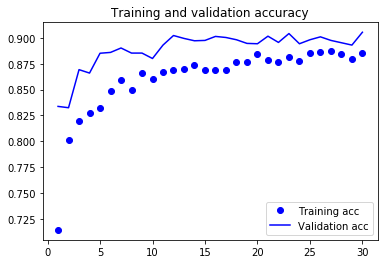

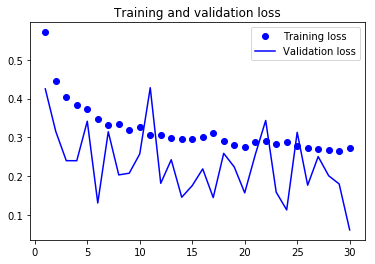

In [21]:
model.compile(loss='binary_crossentropy',
             optimizer = optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data = validation_generator,
    validation_steps=50,
    verbose=2)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### TestDataset 확인

In [22]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150,150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate_generator(test_generator,steps=50)
print('test_acc',test_acc)

Found 1000 images belonging to 2 classes.
('test_acc', 0.9010000228881836)


#### 미세조정
위에서 VGG16 Model에 FC Layer만 제거하고 FC Layer를 새롭게 추가하고 Parameter를 Training하였다.  
**Keras는 또한 쉽게 기존 Model의 Layer또한 Hyerparameter를 Tuning할 수 있게 제공한다.**  
기존 conv_base(VGG 16)을 살펴보면 다음과 같다.  
```code
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       295168    
_________________________________________________________________
block3_conv2 (Conv2D)        (None, 37, 37, 256)       590080    
_________________________________________________________________
block3_conv3 (Conv2D)        (None, 37, 37, 256)       590080    
_________________________________________________________________
block3_pool (MaxPooling2D)   (None, 18, 18, 256)       0         
_________________________________________________________________
block4_conv1 (Conv2D)        (None, 18, 18, 512)       1180160   
_________________________________________________________________
block4_conv2 (Conv2D)        (None, 18, 18, 512)       2359808   
_________________________________________________________________
block4_conv3 (Conv2D)        (None, 18, 18, 512)       2359808   
_________________________________________________________________
block4_pool (MaxPooling2D)   (None, 9, 9, 512)         0         
_________________________________________________________________
block5_conv1 (Conv2D)        (None, 9, 9, 512)         2359808   
_________________________________________________________________
block5_conv2 (Conv2D)        (None, 9, 9, 512)         2359808   
_________________________________________________________________
block5_conv3 (Conv2D)        (None, 9, 9, 512)         2359808   
_________________________________________________________________
block5_pool (MaxPooling2D)   (None, 4, 4, 512)         0         
=================================================================
```
아래 Code는 이러한 VGG Network에서 특정 Layer 들의 Parameter를 Training 가능하게 변경하는 법 이다.

In [ ]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

### CNN 학습 시각화
Tensorflow나 Pytorch에서 다루지 못한 내용이다.  
매우 하고 싶었으나 어떻게 접근하여야 하는지 몰라서 못하고 있었는데 Keras예제를 다루는 책에서 어떻게 학습이 진행되고 각각의 Filter와 Heatmap에 대한 접근방식에 대하여 소개한다.  
**다양한 기법들이 있으나 가장 사용이 편하고 유용한 3가지 기법에 대해서 알아본다.**  
- CNN 중간층의 출력(충간층에 있는 활성화)을 시각화하기: 연속된 CNN층이 입력을 어떻게 변형시키는지 이해하고 개별적인 CNN Filter의 의미를 파악하는데 사용한다.
- CNN Filter Visualization: CNN Filter가 찾으려는 시각적인 Pattern과 개념이 무엇인지 상세하게 이해하는데 도움이 된다.
- 클래스 활성화에 대한 히트맵을 이미지에 시각화하기: 이미지의 어느 부분이 주어진 클래스에 속하는데 기여했는지 이해하고 이미지에서 객체 위치를 추정(localization)하는데 도움을 줍니다.

#### CNN 중간층의 출력을 시각화하기

**Cat vs Dogs Model 불러오기**  
Training하여 저장된 Model을 불러와서 확인한다.

In [29]:
model = load_model('./Model/cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

**개별 이미지 전처리 하기**  
먼저 CNN의 중간층의 출력을 하기 위해서 미리 Training 시킨 Keras의 Model에 넣은 Image를 전처리 하는 과정이다.

(1, 150, 150, 3)


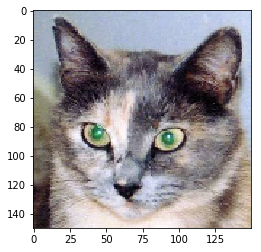

In [28]:
img_path = './Dataset/cat_dog/test/cats/cat.1700.jpg'
img = image.load_img(img_path,target_size=(150,150))

img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor,axis=0) # 이미지를 4D 텐서로 변경, Batch_size로서 Training하였으므로 Dimension을 늘려야 한다.
img_tensor /= 255. # Input Image Data Preprocessing과 같은 과정을 거치게 한다.

print(img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show()

**Model 자르기**  
Training된 Model을 가져오고 Input으로 넣을 Data또한 전처리가 끝난 상태이다.  
이러한 상황에서 Model의 특정 부분을 잘라서 가져온다.  
현재 위에서의 Model을 위에서 살펴보면 총 12개의 Layer로 구성되어있다.  
아래 Code를 통하여 Model에서 1 Layer(conv2d_5) ~ 8 Layer(max_pooling2d_8)까지의 Output을 저장한다.

In [30]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

for act in activations:
    print(act.shape)

(1, 148, 148, 32)
(1, 74, 74, 32)
(1, 72, 72, 64)
(1, 36, 36, 64)
(1, 34, 34, 128)
(1, 17, 17, 128)
(1, 15, 15, 128)
(1, 7, 7, 128)


**1 Layer(conv2d_5) 20번째 Channel 시각화**  
위에서 Training된 Model에 Input으로 Data를 넣었을 경우 1 Layer(conv2d_5)에서 20번째 Channel의 결과를 확인한다.  
아래 결과를 확인하면 Image가 정확하지 않지만 **대각선 Edge를 주로 Feature로서 특징을 잡아낸 것을 확인할 수 있다.**

(1, 148, 148, 32)


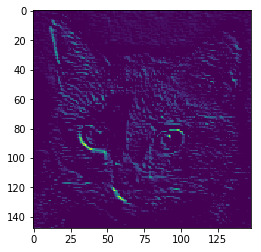

In [37]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)
plt.imshow(first_layer_activation[0,:,:,10],cmap='viridis')

**모든 Layer의 이미지 출력**  
위의 과정에서 Image의 Pixel를 255로 나누어서 0~1사이의 값으로서 표현하여 Input을 적용하였다.  
따라서 Image를 0 ~ 255의 값으로서 표현하기 위하여 다음과 같은 과정을 거친다.  
1. 각 Layer의 Output Normalization
2. Normalization Output을 Z-score로서 표현
3. 2의 과정의 Output을 0 ~ 255의 값으로서 표현해야 한다.

2,3의 과정을 자세히 살펴보면 다음과 같은 과정으로서 이루워진다.  
표준값 z는 원수치인 x가 평균에서 얼마나 떨어져 있는지를 나타낸다.  
음수이면 평균 이하, 양수이면 평균 이상이다.  
<p>$$z = \frac{x-u}{\sigma}$$</p>

위의 과정에서 Parameter들은 다음과 같은 의미를 가진다.  
- x: 정상화되는 원수치
- <span>$\sigma$</span>: 모집단에서의 표준편차
- u: 모집단에서의 평균

따라서 x = 256의 값을 가지게 된다.0 ~ 255사이의 값으로 나타내야 되므로  
u는 0 ~ 255사이의 중앙값인 128을 가진다. 모집단의 크기가 충분히 크면 평균은 중앙값으로 수렴할 것이라는 예상 때문이다.  
**중요한 것은 여기서의 표준편차(<span>$\sigma$</span>)로서 몇% 이상의 값들을 뽑아낼지 정할 수 있다.**  
- 표준점수 0.0(=편차치 50) 이상은 전체의 50％이다.
- 표준점수 1.0(=편차치 60) 이상은 전체의 15.866％이다.
- 표준점수 2.0(=편차치 70) 이상은 전체의 2.275％이다.
- 표준점수 3.0(=편차치 80) 이상은 전체의 0.13499％이다.
- 표준점수 4.0(=편차치 90) 이상은 전체의 0.00315％이다.
- 표준점수 5.0(=편차치 100) 이상은 전체의 0.00002％이다.

아래 코드에서는 z를 2의 값을 취하게 하였다.  
따라서 다음과 같은 편차를 구할 수 있다.  
<p>$$2 = \frac{256-128}{\sigma}$$</p>
<p>$$\sigma = 64$$</p>

따라서 우리는 양측절단을 하게되었을 경우 100 - 2.275 * 2 % 즉, 대략 95%의 값들을 취하여 확인한다.  
참고: <a href="https://ko.wikipedia.org/wiki/%ED%91%9C%EC%A4%80_%EC%A0%90%EC%88%98">Wikipedia</a>

아래 결과를 살펴보게 되면 머리속으로는 이해하였지만 실제로 결과로서 확인할 수 있다.  
**Layer가 깊어짐에 따라서 추상적인 Feature를 뽑아내는 것을 발견할 수 있고 하나 더 중요한 것은 Layer가 깊어짐에 따라서 검은색 박스로서 표현된 활성화되지 않는 Filter가 발견된다.**  
**이러한 Filter는 Filter에 인코딩된 패턴이 입력 이미지에 나타나지 않았다는 것을 의미한다.**

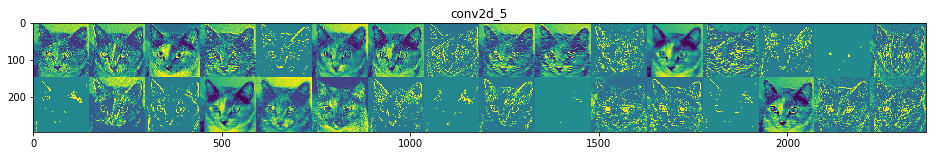

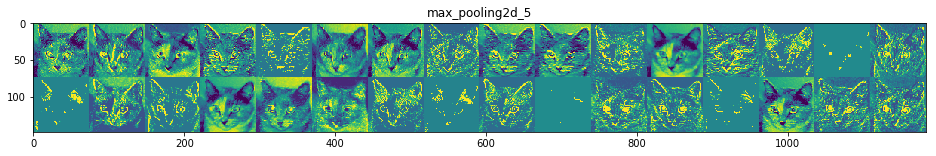

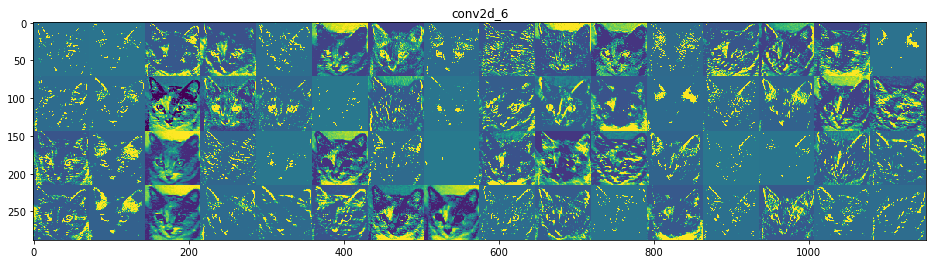

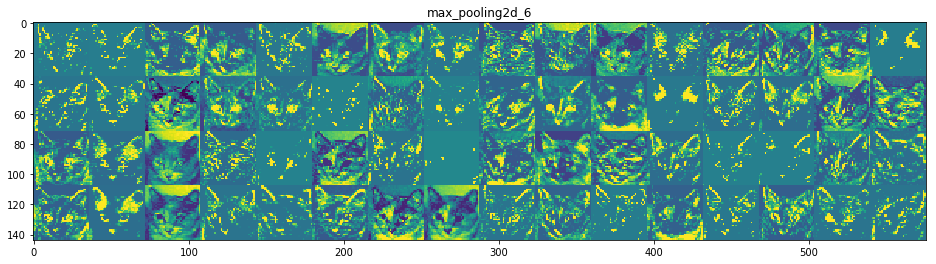

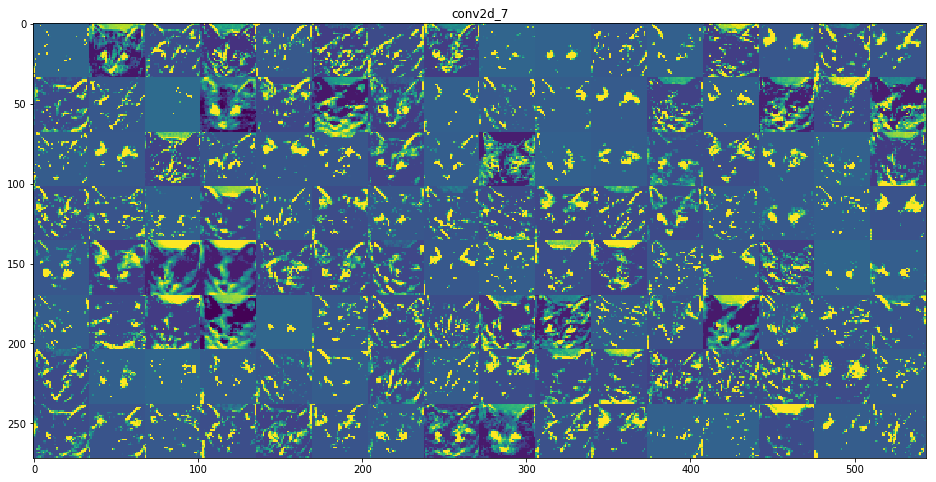

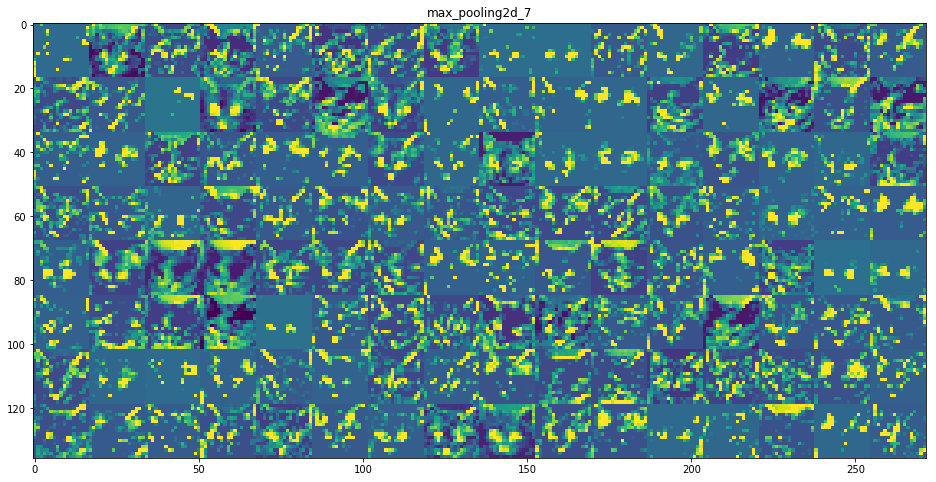

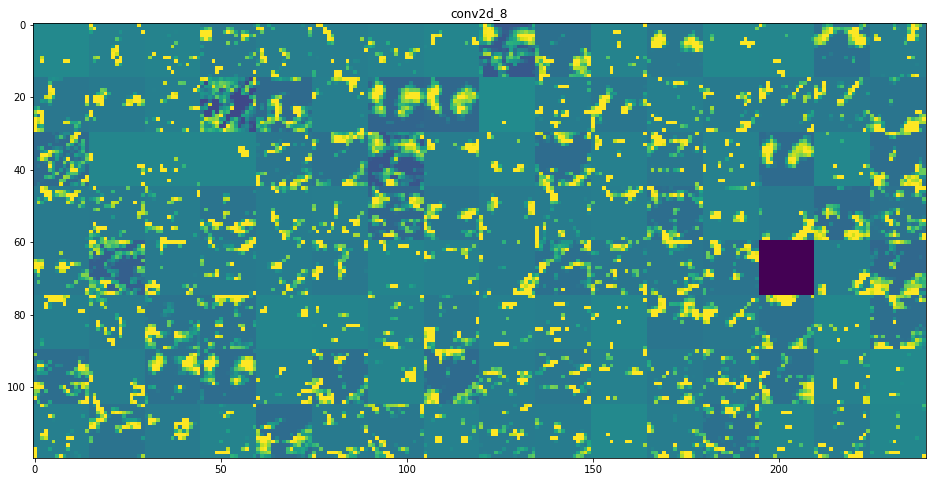

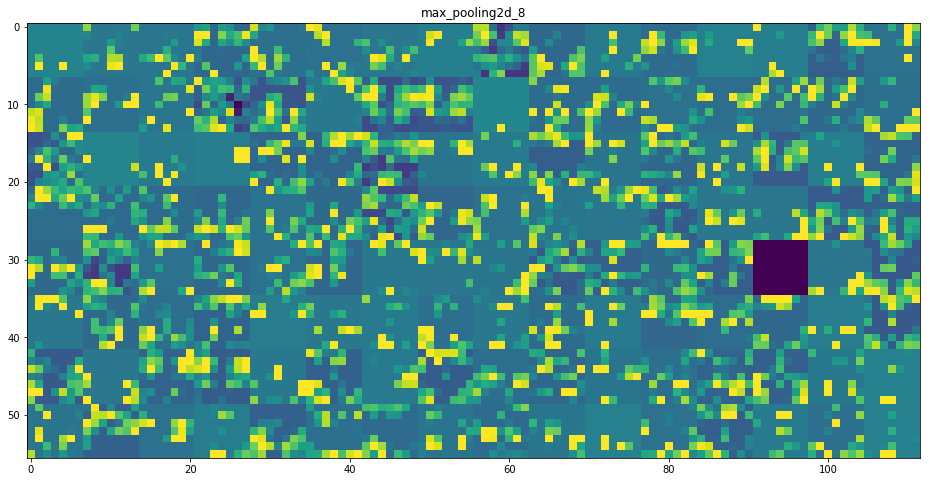

In [50]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
image_per_row = 16 #pyplot으로 보여줄 한 줄의 Image의 개수

for layer_name, layer_activation in zip(layer_names,activations):
    # 각 Layer에서의 Feature(Channel)의 개수와 Size
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    
    # pyplot으로 그릴 Grid의 Size선언
    n_cols = n_features//image_per_row
    display_grid = np.zeros((size*n_cols,image_per_row*size))
    
    # 하나의 큰 Grid의 개별요소를 그린다.
    for col in range(n_cols):
        for row in range(image_per_row):
            channel_image = layer_activation[0,:,:,col*image_per_row+row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *=64
            channel_image +=128
            channel_image = np.clip(channel_image,0,255).astype('uint8')
            display_grid[col*size:(col+1)*size,row*size:(row+1)*size] = channel_image
        
    scale = 1. /size
        
    plt.figure(figsize=(scale*display_grid.shape[1],scale*display_grid.shape[0]))
    
    plt.title(layer_name)
    plt.grid(False)
    
    plt.imshow(display_grid,aspect='auto',cmap='viridis')
    
plt.show()

#### CNN Filter 시각화하기
각각의 Filter를 시각화하는 방법은 매우 간단하나 생각지 못했던 방법이다.  
**Keras 책 예제에서 각각의 Filter를 조사하는 간편한 방법으로서 각 필터가 반응하는 시각적 패턴을 그려본다. 빈 입력 이미지에서 시작해서 특정 필터의 응답을 최대화 하기 위해 CNN입력 이미지에 경사 상승법을 적용한다.**  

**Keras Backend 사용법**  
기본적으로 Keras의 Backend는 Tensorflow로서 정의되어있다.  
파일의 위치는 .keras/keras.json 이며 다음과 같이 정의되어있다.  
```code
{
    "epsilon": 1e-07,
    "floatx": "float32",
    "image_data_format": "channels_last",
    "backend": "tensorflow"
}
```

위의 값을 Backend를 바꾸거나 다른것으로 선정하여 사용할 수 있다.  
EX) 시애노를 백엔드 엔진으로 사용시 keras.json File 변경 사항  
```code
{
    "backend": "theano",
    "floatx": "float32",
    "epsilon": 1e-07,
    "image_data_format": "channels_last"
}
```

참고: <a href="https://blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221220649913&categoryNo=58&parentCategoryNo=0&viewDate=&currentPage=1&postListTopCurrentPage=1&from=postView">똑똑이 블로그</a>

**정규화 과정**  
matplotlib을 활용하여 Image를 출력하여야 하기 때문에 특정값을 0 ~ 255값의 RGB로서 바꾸는 과정이 필요한다. 

In [7]:
model = VGG16(weights='imagenet',include_top=False)

def deprocess_image(x):
    x -=x.mean()
    x /= (x.std()+1e-5)
    x *= 0.1
    
    x +=0.5
    x = np.clip(x,0,1)
    
    x *=255
    x = np.clip(x,0,255).astype('uint8')
    return x


58892288/58889256 [==============================] - 12s 0us/step


**경사 상승법**  
기본적으로 경사 상승법이란 경사 하강법이란 같으나 기울기를 최소화하는 방향이 아닌 최대화 하는 방향으로 Train이 진행된다.  
경사 상승법은 Keras자체에 구현되어있지 않으므로 직접 구현해야 한다. 이렇게 없는 함수를 따로 정의하여 사용하기 위해서 Backend Keras를 불러와서 직접 정의하게 된다.  
경사 상승법의 과정은 아래와 같이 이루워 진다.  

1) Filter의 output으로서 Loss를 구한다.  
2) <code>K.gradient()</code>를 통하여 기울기를 계산한다.  
3) grads에 L2 Normalization을 통하여 정규화를 실시한다. (1e-5는 나눗셈시 0으로 나누에서 발생하는 Error를 제거하기 위하여 매우 작은값으로서 설정한 것 입니다.)  
4) <code>K.Function()</code>을 통하여 Train 함수를 설정한다. Input을 넣었을 경우 위에서 선언한 Loss와 Grads를 반환하는 함수이다.  
5) Learning Rate(step)를 1로서 선언, Epoch를 40으로 선언 한다.  
6) 처음 이미지를 Color Image와 Noise가 낀 이미지로서 선언한다.  
7) Train을 진행한다. 중요한점은 경사 상승법을 사용한 것이고 차이점은 다음과 같다.  

- 경사 상승법: <code>input_img_data +=grad_value*step</code>
- 경사 하강법: <code>input_img_data -=grad_value*step</code>

위의 예시처럼 Gradinet가 최소화하는 방향이 아닌 최대화 하는 곳을 찾아서 Train을 진행한다.  
8) Train된 Image를 Plot으로 시각화 한다.

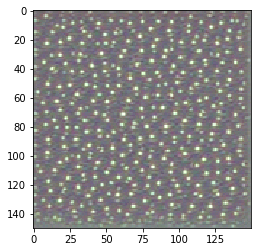

In [10]:
def generate_pattern(layer_name,filter_index,size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    grads = K.gradients(loss,model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input],[loss,grads])
    input_img_data = np.random.random((1,size,size,3)) * 20 + 128
    
    step = 1
    for i in range(40):
        loss_value,grad_value = iterate([input_img_data])
        input_img_data +=grad_value*step
    
    img = input_img_data[0]
    return deprocess_image(img)

plt.imshow(generate_pattern('block3_conv1',0))

**Layer 전체 Filter 시각화**  
위에서 선언한 generate_pattern() Method를 통하여 Layer전체의 필터를 확인한다.  
간단하게 상위 Layer와 하위 Layer를 확인하였다.  
**중요 한점은 하위 Layer로 갈 수록 점점 더 Filter가 복잡해지고 개선된다는 점 이다. 즉, 상위 Layer에서는 큰 Feature즉, Edge, Corner점에 대해서 판별하고 하위 Layer로 갈 수록 사람이 직접 이해하지는 못하지만 Train된 복잡한 형태로 변화된다.**

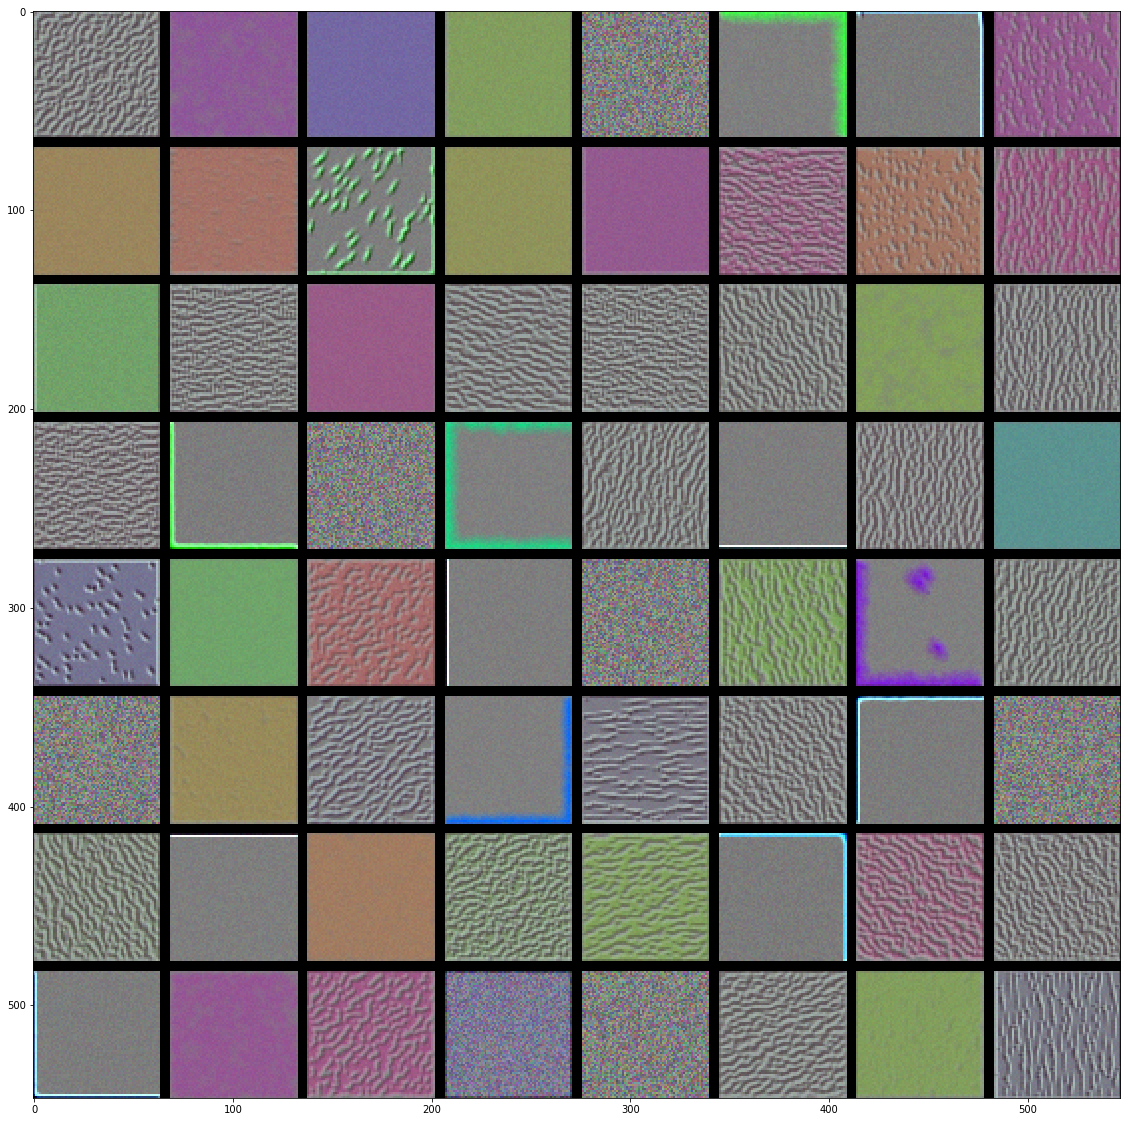

In [61]:
layer_name = 'block1_conv1'
size = 64
margin = 5

results = np.zeros((8*size+7*margin,8*size+7*margin,3),dtype='uint8')

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name,i+(j*8),size=size)
        
        horizontal_start = i*size + i*margin
        horizontal_end = horizontal_start + size
        vertical_start = j*size + j*margin
        vertical_end = vertical_start + size
        results[horizontal_start:horizontal_end,vertical_start:vertical_end,:] = filter_img
        
plt.figure(figsize=(20,20))
plt.imshow(results)

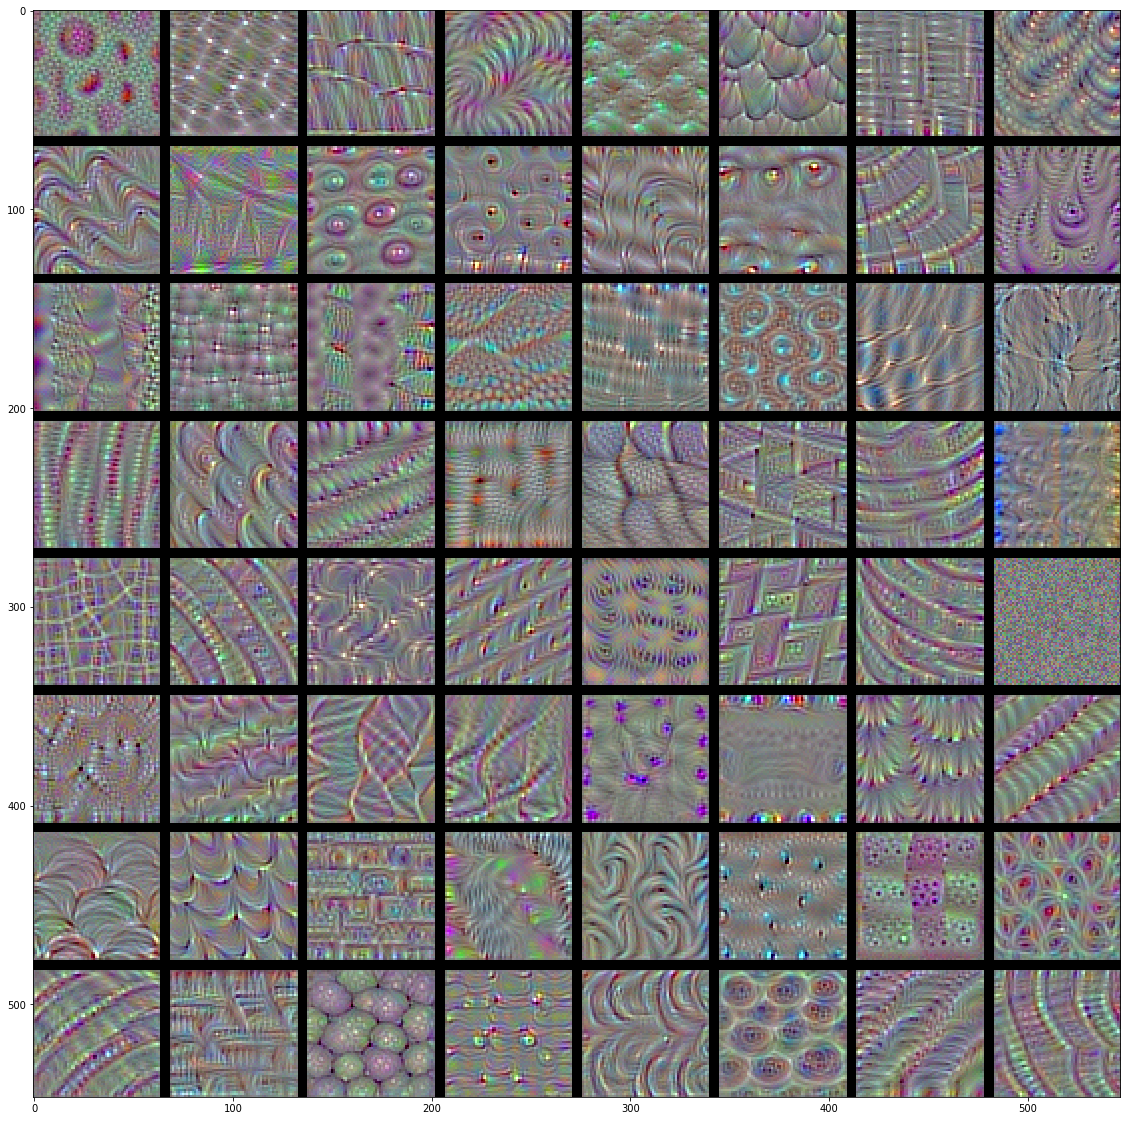

In [11]:
layer_name = 'block4_conv1'
size = 64
margin = 5

results = np.zeros((8*size+7*margin,8*size+7*margin,3),dtype='uint8')

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name,i+(j*8),size=size)
        
        horizontal_start = i*size + i*margin
        horizontal_end = horizontal_start + size
        vertical_start = j*size + j*margin
        vertical_end = vertical_start + size
        results[horizontal_start:horizontal_end,vertical_start:vertical_end,:] = filter_img
        
plt.figure(figsize=(20,20))
plt.imshow(results)

#### 클래스 활성화의 히트맵 시각화하기
클래스 활성화 맵(Class Actication Map, CAM)을 시각화 함으로써 다음과 같은 3가지의 장점을 가지게 된다.  
- 이미지의 어느 부분이 컨브넷의 최종 분류 결정에 기여하는지 이해하는데 매우 유용하다.  
- 분류에 실수가 있는 경우 컨브넷의 결정 과정을 디버깅 하는 데 도움된다.
- 이미지에 특정 물체가 있는 위치를 파악하는데 사용할 수 있다.

먼저 VGG Model에서 어떤 Filter를 CAM으로서 활성화할지 알아보기 위한 단계이다.  
아래 Code는 다음과 같은 과정으로 이루워진다.  
1) VGG Model을 그대로 가져온다.
2) Image을 Model Input에 맞게 전처리 과정을 거친다.  
3) Image를 <code>preprocess_input()</code>을 통하여 채널별 컬러 정규화를 실시한다.  
4) <code>model.predict()</code>을 통하여 Model결과 측정  
5) <code>decode_predictions()</code>을 통하여 클래스, 설명, 확률로 디코딩을 실시하고 top=3를 주어서 확률이 가장 큰 요소 3개만을 출력한다.  
6) <code>np.argmax(preds[0])</code>을 통하여 확률이 제일 큰 Index를 찾는다. 즉, 현재 'African_elephant'의 Class는 최종적인 1000개의 Class중에서 어느 Index인지 확인한다.  

In [4]:
model = VGG16(weights='imagenet')

img_path = './Dataset/creative_commons_elephant.jpg'
img = image.load_img(img_path,target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:',decode_predictions(preds,top=3)[0])
print(np.argmax(preds[0]))

Predicted: [('n02504458', 'African_elephant', 0.9101746), ('n01871265', 'tusker', 0.085445076), ('n02504013', 'Indian_elephant', 0.0043368633)]
386


**Grad-CAM 알고리즘**  
아래 Code는 Grad-CAM 알고리즘을 통하여 Heatmap을 뽑아내는 방식이다.  
**CAM이라는 Algorithm 자체가 CNN을 확인할 수 있는 좋은 방법이기 때문에 따로 공부하고 Post하는 방향으로 결정하였다.**  
아직 공부하지 않았지만 Grad-CAM에 대해서 자세한 내용은 아래 링크를 참조하자.  
참고 사항: <a href="https://jsideas.net/grad_cam/">jsideas 블로그</a>

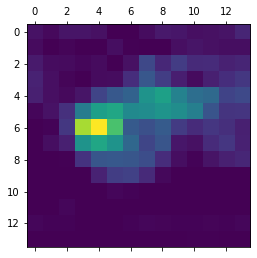

In [19]:
african_elephant_output = model.output[:,386]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(african_elephant_output,last_conv_layer.output)[0]
pooled_grads = K.mean(grads,axis=(0,1,2))
iterate = K.function([model.input],[pooled_grads,last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value,axis=-1)

heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

**결과 저장**

In [28]:
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1],img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

cv2.imwrite('./Dataset/elephant_cam.jpg',superimposed_img)

True